# Bay Wheels Bike Share 2019 Usage Pattern

## by Prem Rajamohan

## Investigation Overview

Bay Wheels is a public bike sharing system in the San Francisco Bay Area, CA. Having lived in SFO for a few years, I have seen hundreds of people biking every day to/from work and it is no doubt that it is a popular service. There were about 500K rides since the launch in 2017 and they had a subscriber count of about 10K in 2018 with 260 stations across SF Bay Area. The aim of this presentation is to focus on usage patterns of the Bay Wheels service in 2019 and provide visualizations that convey some high level insights.


## Dataset Overview

The data for this analysis was obtained from Lyft's website here - https://www.lyft.com/bikes/bay-wheels/system-data. There was 2 years worth of data available (2018 and 2019) but this analysis focusses only on 2019 (~60% of total data) to optimize query performance mainly. Each month's bike usage data was in a separate file and each record in a file is a single 'trip'. The dataset contains information like trip duration, member type, start/end time of the trip, start/end station etc. I derived a few fields like start day, start month etc. from the start time to further enhance the visualizations. Some of the fields had to be 'cleaned' before using them in the analyses.

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [9]:
# load in the dataset into a pandas dataframe

os.chdir("/Users/apoorvadshenoy/Data/DAND - Data Visualization/")
df = pd.read_csv( "full_2_year_data.csv") #file created in the exploratory phase
df_2019 = df[df['start_time'].str[:4] == "2019"].copy() #subset 2019 data
df_2019.shape #2.5 MM out of 4 MM

# create derived fields and clean main issues

#1. Time variables to time format
df_2019['new_start_time'] = pd.to_datetime(df_2019['start_time'])
df_2019['new_end_time'] = pd.to_datetime(df_2019['end_time'])

df_2019.drop(['start_time','end_time'], axis=1, inplace=True)

#2. Changing duration to minutes since that is more easy to understand

df_2019['duration_min'] = round((df_2019['duration_sec']/60),2)
df_2019.drop('duration_sec',axis=1, inplace=True)

#3. Converting user_type to a categorical variable
df_2019['user_type'] = df_2019['user_type'].astype('category')

#4. Converting ID columns to STR from FLOAT
df_2019['start_station_id'] = df_2019['start_station_id'].astype('str')
df_2019['end_station_id'] = df_2019['end_station_id'].astype('str')
df_2019['bike_id'] = df_2019['bike_id'].astype('str')

#5. Create derived fields
df_2019['start_date'] = df_2019.new_start_time.dt.strftime('%Y-%m-%d')
df_2019['start_hour'] = df_2019.new_start_time.dt.strftime('%H')
df_2019['start_day'] = df_2019.new_start_time.dt.strftime('%A')
df_2019['start_month'] = df_2019.new_start_time.dt.strftime('%B')

#6. Convert start day and start month to categorical variables
order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_order = pd.api.types.CategoricalDtype(ordered=True, categories=order)
df_2019['start_month'] = df_2019['start_month'].astype(month_order)

order_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_order = pd.api.types.CategoricalDtype(ordered=True, categories=order_day)
df_2019['start_day'] = df_2019['start_day'].astype(weekday_order)

## Bike Duration and User Type Distribution

The initial visualizations are meant to provide a base understanding for the plots that follow. The two main areas of interest are bike trips duration and the member/non-member split. 

As seen in the graphs below, most of the bike rides are short trips i.e. within 4-10 minutes and majority of the bike rides are from members (subscribers). These visualizations point to the fact that most bike rides are used by regular members for short trips like going to/from work. I can also personally vouch for this fact since I have lived in SFO and I have seen people taking bikes from their train stations to work etc.

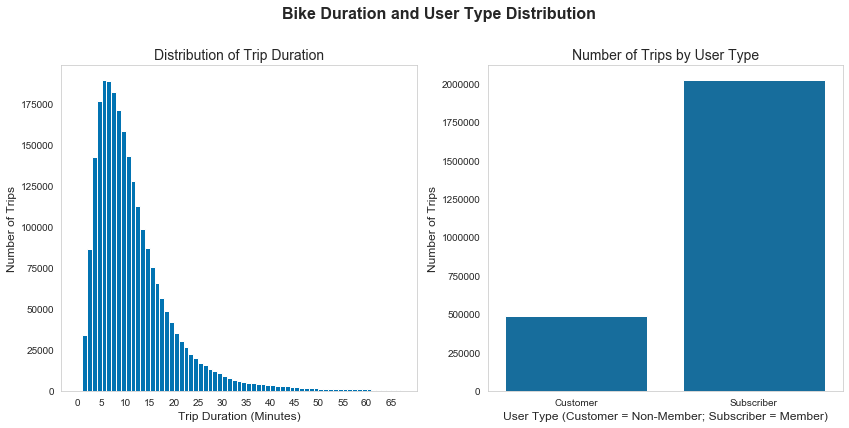

In [18]:
plt.figure(figsize=[14, 6]);
color = sb.color_palette('colorblind')[0];
sb.set_style("whitegrid", {'axes.grid' : False})

plt.subplot(1, 2, 1);
bins = np.arange(0, 68, 1)
plt.hist(data=df_2019, x='duration_min', bins=bins, color=color);
plt.xticks(np.arange(0, 68, 5));
plt.xlabel('Trip Duration (Minutes)', fontsize = 12);
plt.ylabel('Number of Trips', fontsize = 12);
plt.title('Distribution of Trip Duration', fontsize = 14);

plt.subplot(1, 2, 2);
sb.countplot(data=df_2019,x='user_type', color=color);
plt.xlabel('User Type (Customer = Non-Member; Subscriber = Member)', fontsize = 12);
plt.ylabel('Number of Trips', fontsize = 12);
plt.title('Number of Trips by User Type', fontsize = 14);

plt.suptitle('Bike Duration and User Type Distribution', fontsize=16, fontweight='semibold', y=1.015);

## Average Trip Duration by User Type

Now that we know how trip duration and user type splits look individually, in the below chart, we are visualizing average trip duration for each user type. As seen below, customers (non-members) tend to have a bigger spread in average trip duration whereas subscribers (members) tend to fall within a smaller range of trip durations. This could be because of the fact that subscribers are using the bike rides for a routine thing (like going to/from work) but customers probably rent the bike when they have to do a specific thing and that might take longer than an average commute to work.

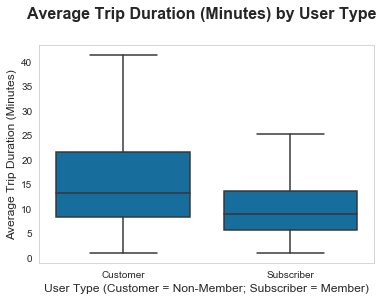

In [24]:
plt.figure(figsize=[6, 4]);
color = sb.color_palette('colorblind')[0];
sb.set_style("whitegrid", {'axes.grid' : False})

sb.boxplot(data=df_2019, x='user_type', y='duration_min', color=color, showfliers=False); #ignoring outliers
plt.xlabel('User Type (Customer = Non-Member; Subscriber = Member)', fontsize=12);
plt.ylabel('Average Trip Duration (Minutes)', fontsize=12);
plt.suptitle('Average Trip Duration (Minutes) by User Type', fontsize=16, fontweight='semibold', y=1.015);

## Average Trip Duration by User Type by Day

The above chart is very insightful and shows a clear difference in bike usage behavior between subscribers and customers. But how does this vary depending on the day of the trip? Well, allow me to show that here. Looking at the below chart, customers (non-members) ride the bikes significantly longer on weekends when compared to weekdays but subscribers (members) do not show such a significant difference. This further strengthens our argument that customers are more leisure riders and hence take longer trips on weekends. However, subscribers are more routine focused and do not exhibit a drastic difference on weekends vs. weekdays.

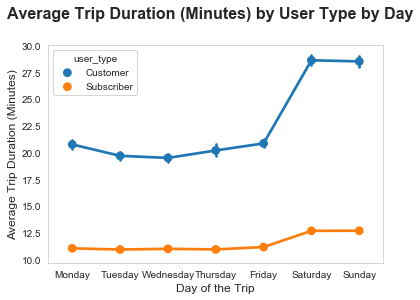

In [25]:
plt.figure(figsize=[6, 4]);
sb.set_style("whitegrid", {'axes.grid' : False})

sb.pointplot(data=df_2019, x='start_day', y='duration_min', hue='user_type');
plt.xlabel('Day of the Trip', fontsize=12);
plt.ylabel('Average Trip Duration (Minutes)', fontsize=12);
plt.suptitle('Average Trip Duration (Minutes) by User Type by Day', fontsize=16, fontweight='semibold', y=1.015);

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

## Summary

As seen in the above plots, we know that subscribers (members) make up a much bigger chunk of bike users compared to customers (non-members). We also know that typically rides are shorter and fall within 4-10 minutes. Looking at the interaction between user types and trip duration, we know that customers have a wider spread in trip duration compared to subscribers and they tend to take longer trips on weekends compared to weekdays. There are other variables of interest in the dataset like rental method, hour of the trip etc. but this presentation revealed some interesting insights on bike usage behaviour by user types and day.